In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from scipy import signal
from scipy.io import wavfile
# from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio
import matplotlib.pyplot as plt

2022-12-18 19:08:20.118525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 19:08:20.285038: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-18 19:08:21.003768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-18 19:08:21.003875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer

In [13]:
physical_devices = tf.config.list_physical_devices('GPU') 


## Processing Data

In [ ]:
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
!tar -xzvf "./nsynth-test.jsonwav.tar.gz"

In [284]:
batch_size = 128

num_channels = 2
num_classes = 24
image_width = 127
image_height = 127
latent_dim = 100 # what is a latent dimension
from keras import backend
# force channels-first ordering
backend.set_image_data_format('channels_last')
# all_labels = np.array([ np.array(i) for i in all_labels])

In [16]:
df = pd.read_json("./nsynth-test/examples.json", orient='index')
data = df[(df['instrument_family_str']=='keyboard') | (df['instrument_family_str']=='organ') ]
data = data.drop(columns=["instrument_str", "instrument", "note_str", "sample_rate", "instrument_family_str"])
data.head()

,qualities,pitch,note,instrument_source_str,velocity,qualities_str,instrument_source,instrument_family
keyboard_electronic_001-021-127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,299359,electronic,127,[],1,4
keyboard_electronic_001-063-075,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",63,51390,electronic,75,[dark],1,4
keyboard_electronic_098-023-050,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]",23,234194,electronic,50,"[dark, distortion]",1,4
organ_electronic_057-056-127,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",56,254994,electronic,127,[dark],1,6
organ_electronic_113-081-127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",81,213923,electronic,127,[],1,6


In [17]:
data['qualities'] = data['qualities'].apply(lambda x: [str(i) for i in x])
data['qualities'] = data['qualities'].apply(lambda x: ''.join(x))

In [19]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
encoded_qualities = le.fit_transform(data['qualities'])
# Using .fit_transform function to fit label
# encoder and return encoded label
encoded_qualities

array([ 0, 13, 16, ...,  0,  8, 13])

In [20]:
data['qualities'] = encoded_qualities

In [21]:
qualities_list = le.inverse_transform(encoded_qualities) # just in case 

In [22]:
len(encoded_qualities)

1268

In [340]:
from numpy import moveaxis
from IPython.display import Audio, display
# Function written by Leo
def spectrogramify(instance, phase, nperseg=1000):
    dir = "./nsynth-" + str(phase) + "/audio/" + str(instance) + ".wav"
    sample_rate, samples = wavfile.read(dir)
    frequencies, times, spectrogram = signal.stft(samples, fs=sample_rate, nperseg=nperseg)
    return sample_rate, frequencies, times, spectrogram

# Function written by Leo

def decompose_spect(y):
    y_real = []
    y_imag = []
    for i in range(len(y)):
        print(len(y[i]))
        y_real.append(y[i].real)
        y_imag.append(y[i].imag)
    return np.array(y_real), np.array(y_imag)

# Function written by Leo

def recompose_spect(y_real, y_imag):
    y = 1j*y_imag
    y += y_real
    return np.array(y)

from IPython.display import Audio, display
def spectro_to_wav(spectrogram, sample_rate = 16000):
    _, gen = signal.istft(spectrogram, sample_rate)
    wavfile.write("output.wav", sample_rate, gen.astype(np.int16))
    return True

def spectro_to_audio(spectrogram, sample_rate = 16000):
    spectro_to_wav(spectrogram, sample_rate)
    wav = "output.wav"
    display(Audio(wav, autoplay=True))

def show_spectro(times, frequencies, spectrogram):
    f = plt.figure()
    f.set_figwidth(5)
    f.set_figheight(3)
    
    plt.pcolormesh(times, frequencies, np.abs(spectrogram))
    # plt.ylabel('Frequency [Hz]')
    # plt.xlabel('Time [sec]')
    plt.ylim([0, 2000])
    f.savefig('spec.png')

In [325]:
def quality_selector(category):
    datasetForCategory = data[data['qualities']==category]
    sample = datasetForCategory.sample(1)
    _, frequencies, times, spectrogram = spectrogramify(sample.index[0], "test")
    spectro_to_audio(spectrogram)
    show_spectro(times,frequencies,spectrogram)
    



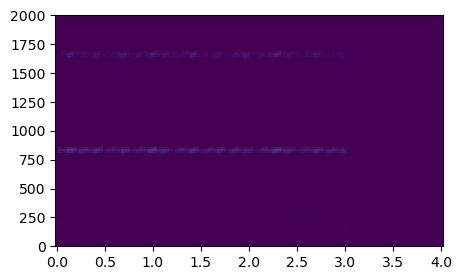

In [326]:
quality_selector(0)

In [226]:
y = {"instance": [], "spectrogram": [], "freq": [], "times": []}

for instance in data.index:
    _, frequencies, times, spectrogram = spectrogramify(instance, "test")
    y["instance"].append(instance)
    y["spectrogram"].append(spectrogram[:127,:127])
    y["freq"].append(frequencies)
    y["times"].append(times)

In [316]:
y_real_test, y_imag_test = decompose_spect(y["spectrogram"])

X = [np.array(y_real), np.array(y_imag)]


In [285]:
all_digits = np.reshape(X , (-1,127, 127,2))
all_labels = keras.utils.to_categorical(encoded_qualities,num_classes )

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")
all_labels

Shape of training images: (1268, 127, 127, 2)
Shape of training labels: (1268, 24)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Model

In [286]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

124 26


In [335]:
#Creating the discriminator and generator

discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((127,127,discriminator_in_channels)),
        
        layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(127, 127,3)),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(momentum=0.8),
        layers.Dropout(0.4),
        layers.Conv2D(64, (3,3), strides=(2, 2),input_shape=(127, 127,3), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.BatchNormalization(momentum=0.8),
        layers.Flatten(),
        layers.Dense(1, activation='tanh'),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dropout(0.2),
        layers.Dense(64 * 5 * 5, input_dim=15),
        layers.ReLU(),
        layers.Reshape((5, 5, 64)),
        layers.BatchNormalization(momentum=0.8),
        # Upsample
        layers.UpSampling2D(),
        layers.Conv2D(64, (3,3), padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(momentum=0.8),
        # Upsample
        layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'),
        layers.ReLU(),
        layers.UpSampling2D(),
        layers.BatchNormalization(momentum=0.8),
        # Upsample
        layers.Conv2DTranspose(64, (8,8), strides=(3,3),output_padding=2),
        layers.ReLU(),
        layers.BatchNormalization(momentum=0.8),
        layers.Conv2DTranspose(2, (1,1), strides=(1,1))],
    name="generator",
)

In [336]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_162 (Conv2D)         (None, 64, 64, 64)        15040     
                                                                 
 leaky_re_lu_108 (LeakyReLU)  (None, 64, 64, 64)       0         
                                                                 
 batch_normalization_323 (Ba  (None, 64, 64, 64)       256       
 tchNormalization)                                               
                                                                 
 dropout_160 (Dropout)       (None, 64, 64, 64)        0         
                                                                 
 conv2d_163 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 leaky_re_lu_109 (LeakyReLU)  (None, 32, 32, 64)       0         
                                                     

In [337]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_162 (Dropout)       (None, 124)               0         
                                                                 
 dense_109 (Dense)           (None, 1600)              200000    
                                                                 
 re_lu_215 (ReLU)            (None, 1600)              0         
                                                                 
 reshape_54 (Reshape)        (None, 5, 5, 64)          0         
                                                                 
 batch_normalization_325 (Ba  (None, 5, 5, 64)         256       
 tchNormalization)                                               
                                                                 
 up_sampling2d_108 (UpSampli  (None, 10, 10, 64)       0         
 ng2D)                                                   

In [338]:
#Creating a ConditionalGAN model
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    def wasserstein_loss(y_true, y_pred):
        return mean(y_true) * mean(y_pred)
    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data
        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_width * image_height]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_width, image_height, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            
            g_loss = self.loss_fn(misleading_labels, predictions)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

# Training & Predicting

In [339]:
!mkdir -p saved_model

cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
)

history_2 = cond_gan.fit(dataset, epochs=50)
cond_gan.save('saved_model/cgan_generator.h5',save_format='tf')

Epoch 1/50
10/10 [==============================] - 4s 276ms/step - g_loss: 0.8954 - d_loss: 0.5629
Epoch 2/50
10/10 [==============================] - 3s 276ms/step - g_loss: 1.2913 - d_loss: 0.3403
Epoch 3/50
10/10 [==============================] - 3s 276ms/step - g_loss: 1.3117 - d_loss: 0.3317
Epoch 4/50
10/10 [==============================] - 3s 276ms/step - g_loss: 1.3104 - d_loss: 0.3166
Epoch 5/50
10/10 [==============================] - 3s 276ms/step - g_loss: 1.3039 - d_loss: 0.3188
Epoch 6/50
10/10 [==============================] - 3s 276ms/step - g_loss: 1.3133 - d_loss: 0.3208
Epoch 7/50
10/10 [==============================] - 3s 276ms/step - g_loss: 1.3133 - d_loss: 0.3167
Epoch 8/50
10/10 [==============================] - 3s 276ms/step - g_loss: 1.3133 - d_loss: 0.3165
Epoch 9/50
10/10 [==============================] - 3s 276ms/step - g_loss: 1.3133 - d_loss: 0.3143
Epoch 10/50
 3/10 [========>.....................] - ETA: 1s - g_loss: 1.3133 - d_loss: 0.3161

KeyboardInterrupt: 

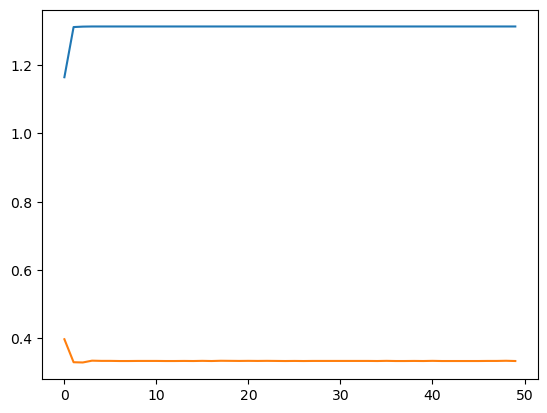

In [251]:
#History 2 plot
'''
did not have the relu as the activation function for the last conv transpose layer fo the generator, 
this model already had the batch norm without the momentum parameter

'''
plt.plot([i for i in range(50)],history_2.history['g_loss'])
plt.plot([i for i in range(50)],history_2.history['d_loss'])
plt.show()

In [313]:
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 1  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label))

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, first_label], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class =23 # @param {type:"slider", min:0, max:54, step:1}
end_class = 11 # @param {type:"slider", min:0, max:54, step:1}

fake_images = interpolate_class(start_class, end_class)

1/1 [==============================] - 0s 20ms/step


(1, 127, 127, 2)
[[[[ 0.54431945 -0.7031304 ]
   [ 0.69059753 -0.04622528]
   [-0.52881604 -0.6407427 ]
   ...
   [-0.01792737 -0.13878436]
   [-0.0783425   0.0360597 ]
   [-0.0783425   0.0360597 ]]

  [[ 0.49752975 -0.58387655]
   [-0.56449     0.29244062]
   [-0.65840447  0.48869652]
   ...
   [-0.41661257  0.17433454]
   [-0.0783425   0.0360597 ]
   [-0.0783425   0.0360597 ]]

  [[-0.32658413 -0.3719458 ]
   [-0.51134235  0.25438404]
   [ 0.14934987  0.51451004]
   ...
   [-0.32140413  0.16328095]
   [-0.0783425   0.0360597 ]
   [-0.0783425   0.0360597 ]]

  ...

  [[-0.29555628 -0.14772134]
   [-0.5290884   0.37321368]
   [-0.23785754  0.56387997]
   ...
   [-0.39491752  0.11670791]
   [-0.0783425   0.0360597 ]
   [-0.0783425   0.0360597 ]]

  [[-0.0783425   0.0360597 ]
   [-0.0783425   0.0360597 ]
   [-0.0783425   0.0360597 ]
   ...
   [-0.0783425   0.0360597 ]
   [-0.0783425   0.0360597 ]
   [-0.0783425   0.0360597 ]]

  [[-0.0783425   0.0360597 ]
   [-0.0783425   0.0360597 ]
   

IndexError: tuple index out of range

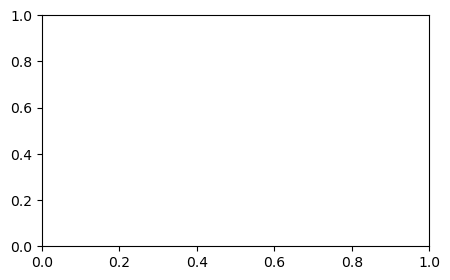

In [334]:
print(fake_images.shape)
print(fake_images)

X_gen = recompose_spect(fake_images[:, :, :,0 ],fake_images[:, :, :, 1] )
print(X_gen.shape)

print(X_gen)
spectro_to_audio(X_gen[0])

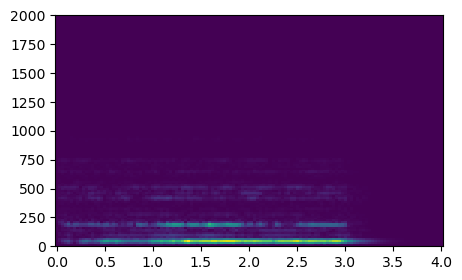

In [329]:
quality_selector(15)
